In [2]:
import os
import rasterio
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from scipy.stats import linregress as lr
import math as mt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
from PIL import Image

In [5]:
def box_count(raster: np.ndarray, box_size: int):
    mask = ~(raster == -9999)
    # print(mask)
    rows, cols = raster.shape
    total_box_count = 0 
    for i in range(0, rows, box_size):
        for j in range(0, cols, box_size):
            end_row = min(i + box_size, rows)
            end_col = min(j + box_size, cols)
            # print(f"For location {i}, {j}, end row is {end_row} and end col is {end_col}")
            current_slice = raster[i:end_row, j:end_col]
            current_mask = mask[i:end_row, j:end_col]

            # valid_vals = current_slice[current_mask] # Original Location
            # if valid_vals.size > 0: # Original
            if np.all(current_mask): # Updated such that if any values are invalid (a.k.a boxes are border boxes) then don't compute
                valid_vals = current_slice[current_mask]
                max_val = np.max(valid_vals)
                min_val = np.min(valid_vals)
                # print(f"max_val = {max_val}, min_val={min_val}")
                hdiff = max_val - min_val # if box_size = 1 - hdiff = 0 // Times 2 to account for 2m by 2m by 1m scale
                box_count = mt.ceil(hdiff / (2*box_size))
                total_box_count += box_count
        # print(f"Total box count for box size {size} is {box_count_for_size}")
    return total_box_count

def fractal_dimension(tif_file: str, box_sizes: List[int], pdf: PdfPages, save_fig: bool):
    with rasterio.open(tif_file) as src:
        image = src.read(1)
    raster = np.array(image)

    counts = [box_count(raster, size) for size in box_sizes]

    log_eps = np.log(1 / np.array(box_sizes))
    log_counts = np.log(counts)

    slope, intercept = np.polyfit(log_eps, log_counts, 1)
    dateyear = tif_file.split('_')[3]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(log_eps, log_counts, 'o', label='Log-Log Data')
    ax.plot(log_eps, slope * log_eps + intercept, 'r', label=f'Fit: slope = {slope:.4f}')
    ax.set_xlabel('log(1/ε)')
    ax.set_ylabel('log(N(ε))')
    ax.set_title(f'Fractal Dimension Estimation\n{dateyear}')
    ax.legend()
    ax.grid(True)
    if save_fig:
        pdf.savefig(fig)

    return slope

In [32]:
def calc_upper_bound(tif_file: str, max_box_size: int, step_size: int):
    with rasterio.open(tif_file) as src:
        image = src.read(1)
    raster = np.array(image)

    box_sizes = list(range(2, max_box_size + 1, step_size))

    prev_slope = 0.0
    counts = []
    upper_sample_bound = 0

    for i in range(len(box_sizes)):
        count = box_count(raster, box_sizes[i])
        counts.append(count)
        log_eps = np.log(1 / np.array(box_sizes[0:i+1]))
        log_counts = np.log(counts[0:i+1])
        slope, intercept = np.polyfit(log_eps, log_counts, 1)
        if slope == None or slope < 0.0:
            slope = 0.0
        if prev_slope > slope:
            break
        upper_sample_bound += 1
        prev_slope = slope
        # print(f"Box size: {box_sizes[i]}, Slope: {slope}")

    fig, ax = plt.subplots(figsize=(8, 6))    
    log_eps = np.log(1 / np.array(box_sizes[0:upper_sample_bound]))
    log_counts = np.log(counts[0:upper_sample_bound])
    ax.plot(log_eps, log_counts, 'o', label='Log-Log Data')
    ax.plot(log_eps, slope * log_eps + intercept, 'r', label=f'Fit: slope = {slope:.4f}')
    ax.set_xlabel('log(1/ε)')
    ax.set_ylabel('log(N(ε))')
    ax.set_title(f'Fractal Dimension Estimation')
    ax.legend()
    ax.grid(True)

    return upper_sample_bound, counts, box_sizes[0:upper_sample_bound]
    


In [45]:
def calc_lower_bound(upper_bound, counts, box_sizes):
    lower_sample_bound = 0.0
    prev_slope = 0.0
    for i in range(0, len(counts)):
        log_eps = np.log(1 / np.array(box_sizes[i:upper_bound]))
        log_counts = np.log(counts[i: upper_bound])
        slope, intercept = np.polyfit(log_eps, log_counts, 1)
        print(f"Slope from {i} to {upper_bound} is {slope}")
        if prev_slope > slope:
            lower_sample_bound = i-1
            break
        prev_slope = slope
    fig, ax = plt.subplots(figsize=(8, 6))    
    log_eps = np.log(1 / np.array(box_sizes[lower_sample_bound:upper_bound]))
    log_counts = np.log(counts[lower_sample_bound:upper_bound])
    ax.plot(log_eps, log_counts, 'o', label='Log-Log Data')
    ax.plot(log_eps, slope * log_eps + intercept, 'r', label=f'Fit: slope = {slope:.4f}')
    ax.set_xlabel('log(1/ε)')
    ax.set_ylabel('log(N(ε))')
    ax.set_title(f'Fractal Dimension Estimation')
    ax.legend()
    ax.grid(True)
    return lower_sample_bound, prev_slope, intercept

C:\Users\andrew72\AppData\Local\Temp\ipykernel_39976\1508974946.py:17: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(log_eps, log_counts, 1)


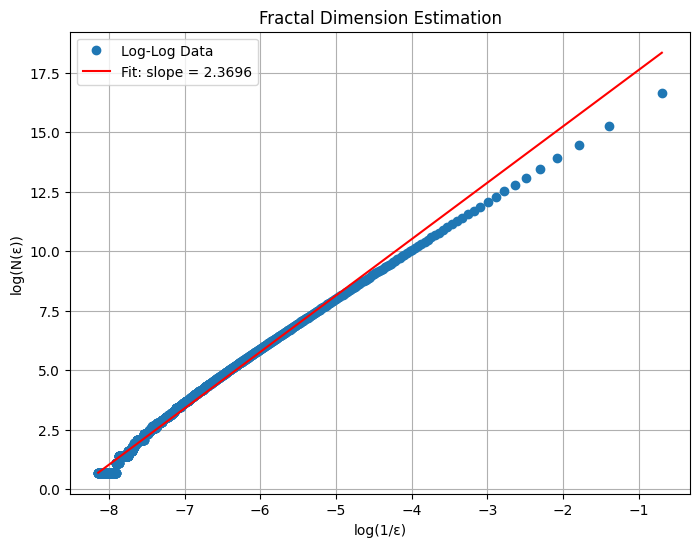

In [33]:
path = 'updated-datasets/SETSM_s2s041_WV03_20240328_1040010092555600_1040010094CC8500_2m_seg1_dem.tif'
upper_bound, box_counts, boxes = calc_upper_bound(tif_file=path, max_box_size=10000, step_size=2)
# Max box size 1000 with step size 2 is fractal dimension 2.1
# At 3432 box size, slope is 2.3696

Slope from 0 to 1716 is 2.369592403498145
Slope from 1 to 1716 is 2.376272054992846
Slope from 2 to 1716 is 2.381530816789412
Slope from 3 to 1716 is 2.386066574368778
Slope from 4 to 1716 is 2.3901385357096845
Slope from 5 to 1716 is 2.3938765441215737
Slope from 6 to 1716 is 2.3973596918707534
Slope from 7 to 1716 is 2.4006388221587565
Slope from 8 to 1716 is 2.4037500040513824
Slope from 9 to 1716 is 2.4067194104129466
Slope from 10 to 1716 is 2.409568019408873
Slope from 11 to 1716 is 2.4123100280010648
Slope from 12 to 1716 is 2.414960625536555
Slope from 13 to 1716 is 2.417526446257435
Slope from 14 to 1716 is 2.4200172095236057
Slope from 15 to 1716 is 2.422441099824393
Slope from 16 to 1716 is 2.424802067591126
Slope from 17 to 1716 is 2.4271095951006836
Slope from 18 to 1716 is 2.4293643956419304
Slope from 19 to 1716 is 2.4315724476694482
Slope from 20 to 1716 is 2.4337347360539634
Slope from 21 to 1716 is 2.4358531186841295
Slope from 22 to 1716 is 2.437935975900822
Slope fr

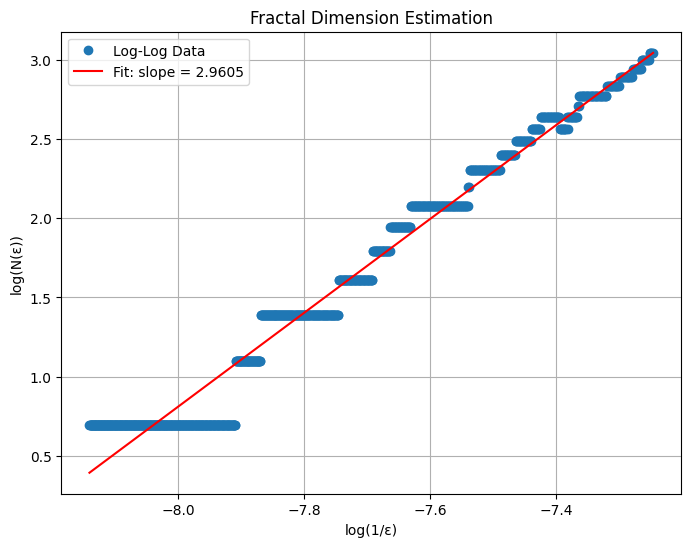

In [46]:
lower_bound, slope, intercept = calc_lower_bound(upper_bound=upper_bound, counts=box_counts, box_sizes=boxes)
# print(lower_bound, upper_bound)

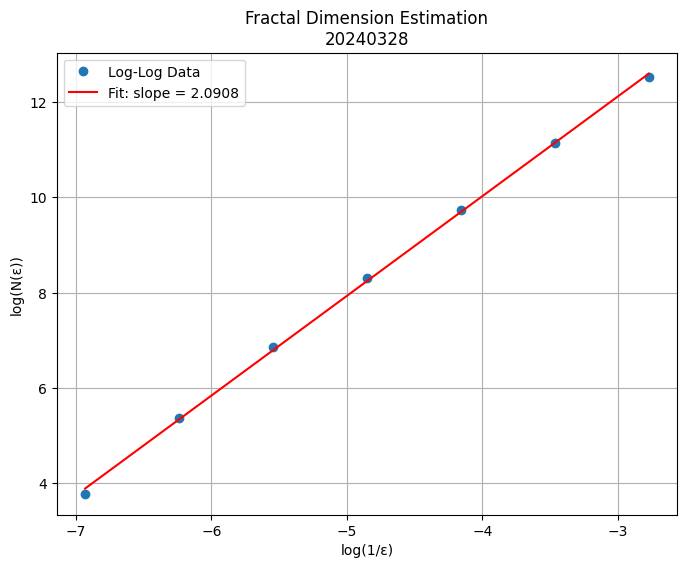

In [8]:
folder_path_relative = "updated-datasets" 
list_of_box_sizes = np.array([16 * 2**i for i in range(7) if 16 * 2**i <= 2048])
path = 'updated-datasets/SETSM_s2s041_WV03_20240328_1040010092555600_1040010094CC8500_2m_seg1_dem.tif' # Rough terrain
with PdfPages("16_to_1024_inc_square2.pdf") as pdf:
    fractal_dimension(tif_file=path, box_sizes=list_of_box_sizes, pdf=pdf, save_fig=False)



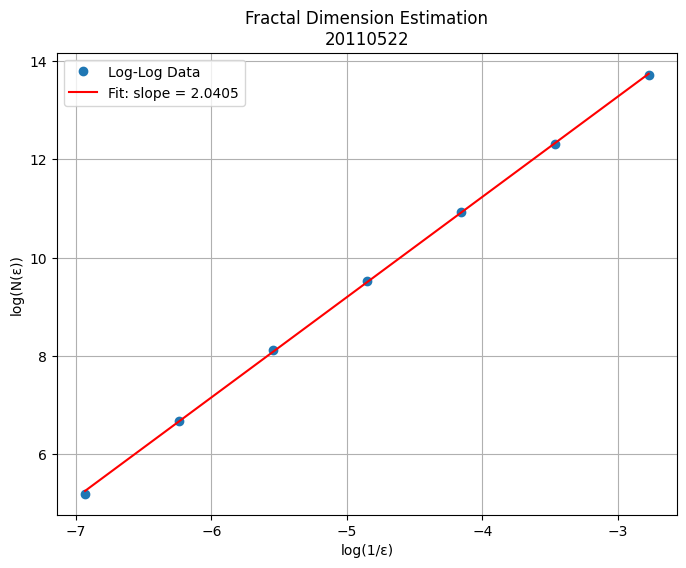

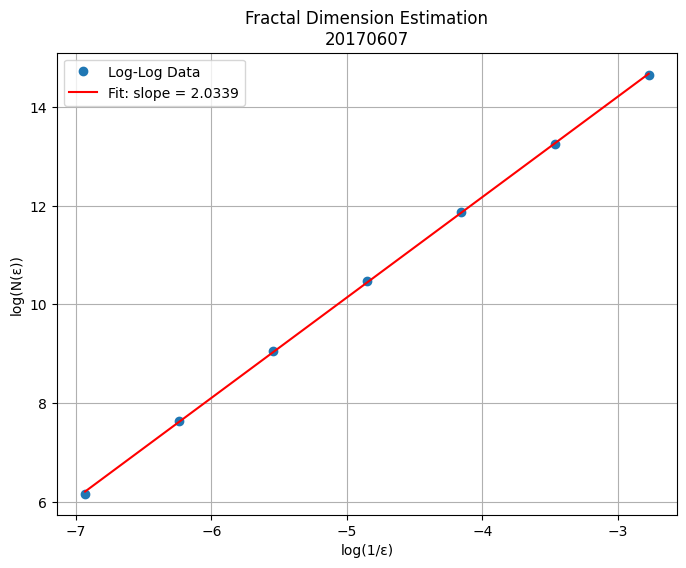

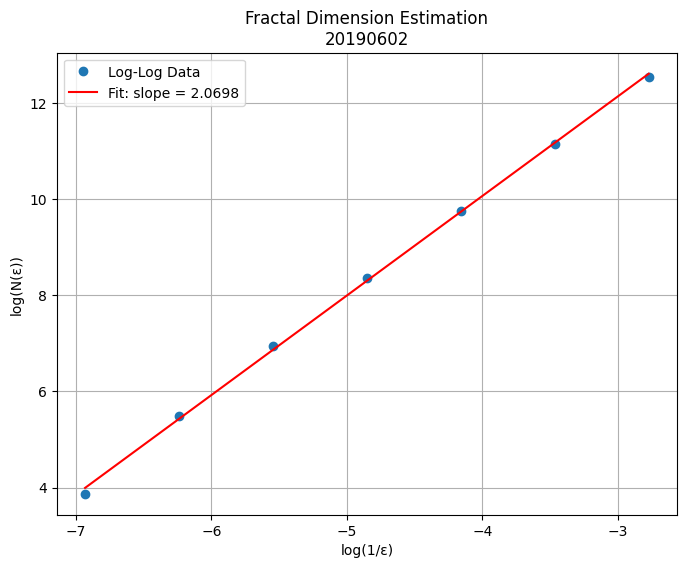

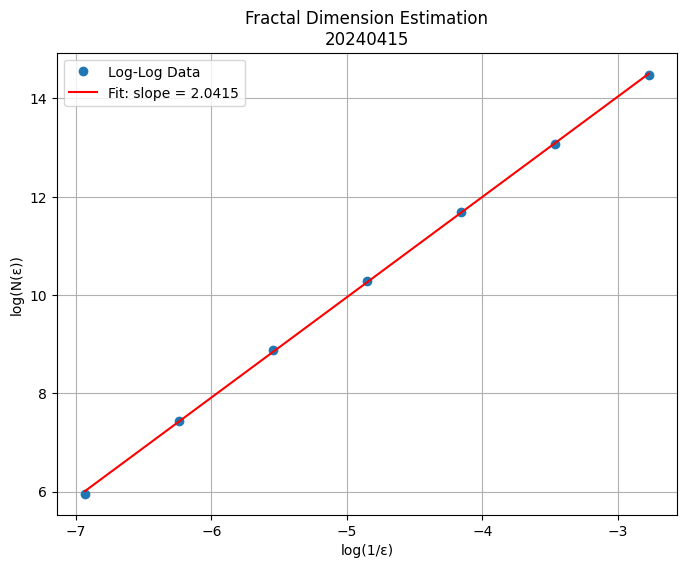

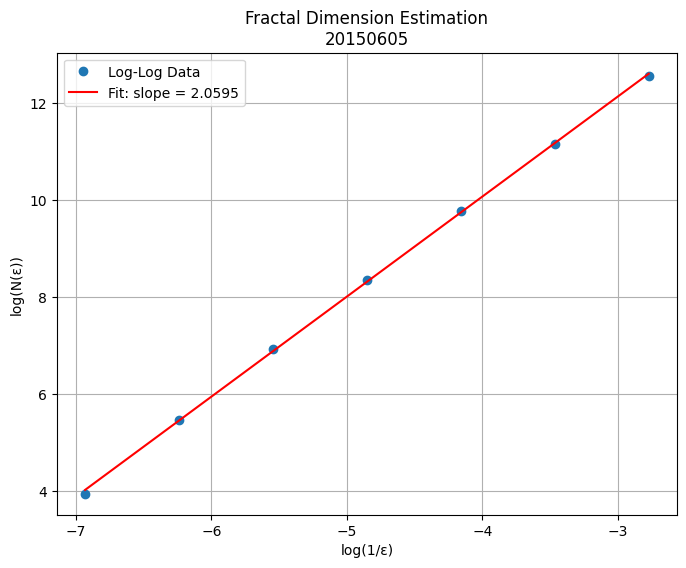

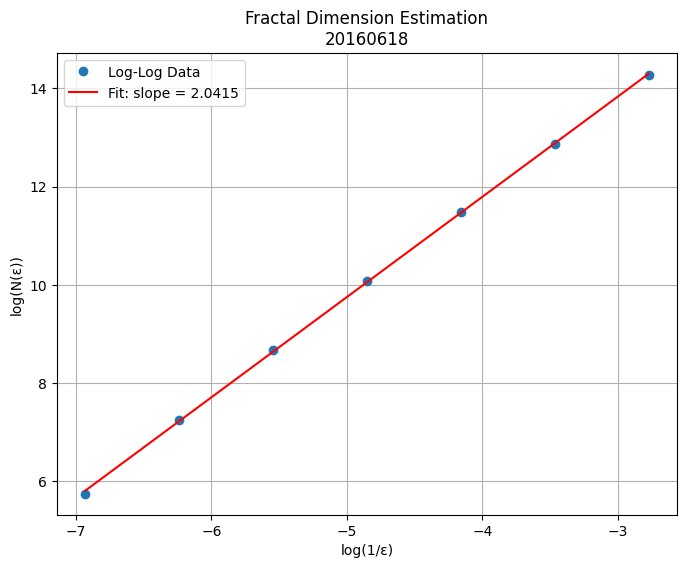

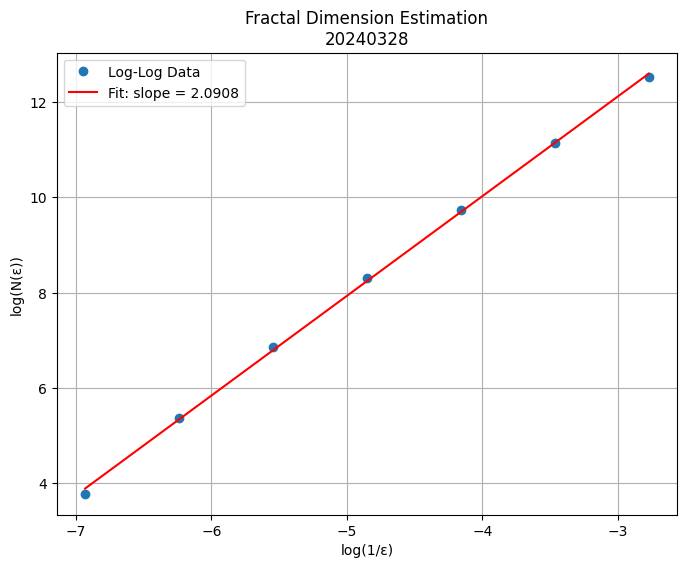

In [9]:
folder_path_relative = "updated-datasets"
list_of_box_sizes = np.array([16 * 2**i for i in range(7) if 16 * 2**i <= 2048])

with PdfPages("all_fractal_dimensions_start_16_end_1024_inc_square2.pdf") as pdf:
    for filename in os.listdir(folder_path_relative):
        file_path = os.path.join(folder_path_relative, filename)
        if os.path.isfile(file_path):
            fractal_dimension(tif_file=file_path, box_sizes=list_of_box_sizes, pdf=pdf, save_fig=True)